In [1]:
import pandas as pd

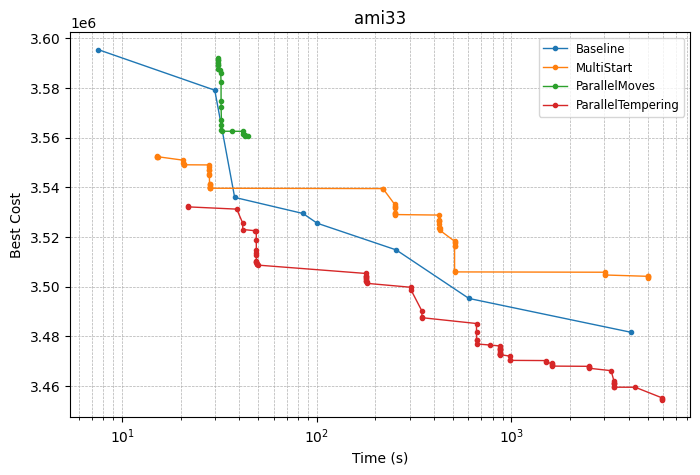

In [39]:
import os
import io
import matplotlib.pyplot as plt

blocks_name = "ami33"

def read_logs_with_blocks(directory="logs"):
    data = {}
    if not os.path.isdir(directory):
        return data

    for filename in os.listdir(directory):
        if blocks_name.lower() in filename.lower() and "metrics" not in filename.lower():
            filepath = os.path.join(directory, filename)
            if not os.path.isfile(filepath):
                continue
            try:
                # 優先使用 pandas 解析常見 CSV 格式
                try:
                    df = pd.read_csv(filepath)
                except Exception:
                    # 如果 pandas 讀取失敗，退回到手動解析
                    with open(filepath, 'r', encoding='utf-8') as f:
                        content = f.read()
                    # 嘗試使用 csv-like string 讀取
                    df = pd.read_csv(io.StringIO(content))

                # 找到時間與成本對應的欄位（不區分大小寫）
                cols_lower = [c.lower() for c in df.columns]
                time_col = next((c for c in df.columns if 'time' in c.lower() or 'timestamp' in c.lower()), None)
                cost_col = next((c for c in df.columns if 'cost' in c.lower() or 'best' in c.lower()), None)

                # 如果沒有自動辨識到，採用預設欄位
                if time_col is None and len(df.columns) >= 1:
                    time_col = df.columns[0]
                if cost_col is None and len(df.columns) >= 2:
                    cost_col = df.columns[1]

                # 轉換為數值清單
                times_list = pd.to_numeric(df[time_col], errors='coerce').dropna().tolist()
                costs_list = pd.to_numeric(df[cost_col], errors='coerce').dropna().tolist()

                # 若兩者長度不等，取最小長度配對
                n = min(len(times_list), len(costs_list))
                if n > 0:
                    data[filename] = (times_list[:n], costs_list[:n])
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    return data

# 讀取 logs（與之前邏輯相同）
log_data = read_logs_with_blocks()

# 根據 base 檔案計算閾值與 cost 限制
base_fname = next((f for f in log_data.keys() if 'baseline' in f.lower()), None)
if base_fname:
    base_times, base_costs = log_data[base_fname]
    base_first_x = base_times[0] if base_times else None
    base_first_y = base_costs[0] if base_costs else None
else:
    base_first_x = None
    base_first_y = None

# 若找不到 base 或值不合理，使用預設
if base_first_x is None or not isinstance(base_first_x, (int, float)):
    x_thresh = 7
else:
    x_thresh = int(max(0, base_first_x - 0.1))

# 若沒找到 base_first_y，則不做 y 篩選（以 +inf 表示）
if base_first_y is None or not isinstance(base_first_y, (int, float)):
    y_limit = float('inf')
else:
    y_limit = base_first_y  # 不取 Y > base 第一個的點

# 使用兩個獨立的 figure / axes（不共用 Y 軸）
# fig1, ax1 = plt.subplots(figsize=(8, 5))
fig2, ax2 = plt.subplots(figsize=(8, 5))

for fname, (t_list, c_list) in log_data.items():
    # 過濾、配對並排序
    paired = [(t, c) for t, c in zip(t_list, c_list) if t is not None and c is not None and t > 0 and c > 0]
    if not paired:
        continue
    paired_sorted = sorted(paired, key=lambda x: x[0])

    # 依照 Y 限制過濾（不取 Y > base 第一個）
    paired_sorted = [p for p in paired_sorted if p[1] <= y_limit]
    if not paired_sorted:
        continue

    # 分割（以計算出來的 x_thresh）
    first_slice = [p for p in paired_sorted if p[0] <= x_thresh]
    second_slice = [p for p in paired_sorted if p[0] > x_thresh]
    
    if fname.split('_')[1] == 'baseline':
        method = 'Baseline'
    else:
        method = fname.split('_')[2]

    if first_slice:
        ts_first, cs_first = zip(*first_slice)
        # ax1.plot(ts_first, cs_first, marker='o', markersize=3, linewidth=1, label=method)
    if second_slice:
        ts_last, cs_last = zip(*second_slice)
        ax2.plot(ts_last, cs_last, marker='o', markersize=3, linewidth=1, label=method)

# # 各自設定標題、軸與格線（Y 軸獨立）
# ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Best Cost')
# ax1.set_title(f'Time <= {x_thresh} (filter: \"{blocks_name}\")')
# ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
# ax1.legend(fontsize='small', loc='best')

ax2.set_xlabel('Time (s)')
ax2.set_xscale('log')
ax2.set_ylabel('Best Cost')
ax2.set_title(f"{blocks_name}")
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend(fontsize='small', loc='best')

plt.show()

# 更新 notebook 中的 axes 變數（方便後續互動）與閾值資訊
axes = [ax2]
base_info = {'base_fname': base_fname, 'base_first_x': base_first_x, 'base_first_y': base_first_y, 'x_thresh': x_thresh, 'y_limit': y_limit}
